# DSCI 100 09 Group 09 Project Report

Andrew Tran, David Wang, Elianna ..., Tosaki ...

## 1. Introduction

Every day, children and adults around the world suffer from a medical complication known as a stroke. A stroke happens when  disruption occurs in the blood supply to the brain. Strokes can have serious and potentially life-threatening consequences, as they can lead to brain damage, disability, or even death. We explored *Kaggle* and chose a stroke data set that contained multiple categories that contribute to stroke. There are several factors that contribute to a persons chances of getting a stroke which include but are not limited to: blood pressure levels, BMI (Body Mass Index), smoking, physical activity, age, and more. Our project aims to predict the likelihood of someone getting a stroke based on their age and stress levels. We want to attempt to answer the following question: How does age and stress levels affect the risks of getting a stroke?

## 2. Methods and Results

Here we start off by opening the following packages: tidyverse, tidymodels and repr. Then we proceeded to install the *kknn* and *cowplot* packages. These packages allowed us to wrangle, classify, and visualize our code. Finally, we set seed to ensure that our data is reproducable.

In [25]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("kknn")
install.packages("cowplot")
set.seed(559)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# We load in the data set from Kaggle

stroke <- read_csv("https://raw.githubusercontent.com/Megunight/dsci100-project/main/stroke_prediction_dataset.csv")

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Step 1. Wrangle and Clean Data

First, we labelled the category names to make the columns easy to interpret and read.

In [36]:
# The columns were labelled as 'X1, X2, X3, etc.' Thus, we renamed the columns to accuractely represent categories.

names(stroke) <- c("patient_id", "patient_name", "age", "gender", "hypertension", "heart_disease", "marital_status",
                  "work_type", "residence_type", "average_glucose_level", "bmi", "smoking_status", "alcohol_intake", "physical_activity",
                  "stroke_history", "family_history_of_stroke", "dietary_habits", "stress_levels", "blood_pressure_levels",
                  "cholesterol_levels", "symptoms", "diagnosis")
head(stroke)

patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
29307,Advika Kota,62,Female,0,0,Single,Private,Urban,91.60,⋯,Social Drinker,High,0,No,Gluten-Free,4.85,132/64,"HDL: 80, LDL: 69",Severe Fatigue,Stroke


In [4]:
#3 different variables have been selected for use

stroke_selected <- stroke |>
                    select(age,
                           stress_levels,
                           diagnosis)

In [5]:
# The sample contained over 15,000 data points. 
# Therefore, we decided to take a random sample of 5000. 
# This would also ensure that our visualization doesn't become too overcrowded. 

stroke_sample <- stroke_selected |>
                sample_n(5000)

We start by splitting the data. Seventy-five percent of the data goes into our training set while the remaining twenty-five percent go towards the testing set. From this point onwards, we will only continue to work with the the training set and leave the testing set aside.

In [6]:
stroke_split <- initial_split(stroke_sample, prop = 0.75, strata = diagnosis)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

We wrangle our age and stress categories by grouping them. Age and class were classified into separate numerical categories to ensure that we could create a visualization that is feasible to work with. Had we not mutated it, there would have been an extremely overwhelming amount of data points/numbers on the visualization. 

Diagnosis needed to be turned into a factor from a character. This allows us to create a confusion matrix, since it only allows numerics.

In [7]:
stroke_training <- stroke_training |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )


stroke_training <- stroke_training |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) 

stroke_testing <- stroke_testing |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )

stroke_testing <- stroke_testing |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) 

stroke_training <- stroke_training |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

stroke_testing <- stroke_testing |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

In [8]:
# We create a small table to show the count of the diagnosis

stroke_obs <- stroke_training |>
                group_by(diagnosis) |>
                summarise(count = n())
stroke_obs

diagnosis,count
<chr>,<int>
No Stroke,1843
Stroke,1906


### Step 2. Visualization of Diagnosis

Next, we create two bar plots to represent the diagnosis depending on either people's ages or stress levels.

Looking at the age bar graph, we can see that people aged 0-10 or 90-100 tended to encounter less strokes, whereas people aged 
10-90 encountered similar number of strokes.

Looking at the stress levels bar graph, we can see that there isn't much of a correlation between stress levels and stroke diagnosis. The level of stroke diagnosis does not appear to depend on a person's stress level.

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


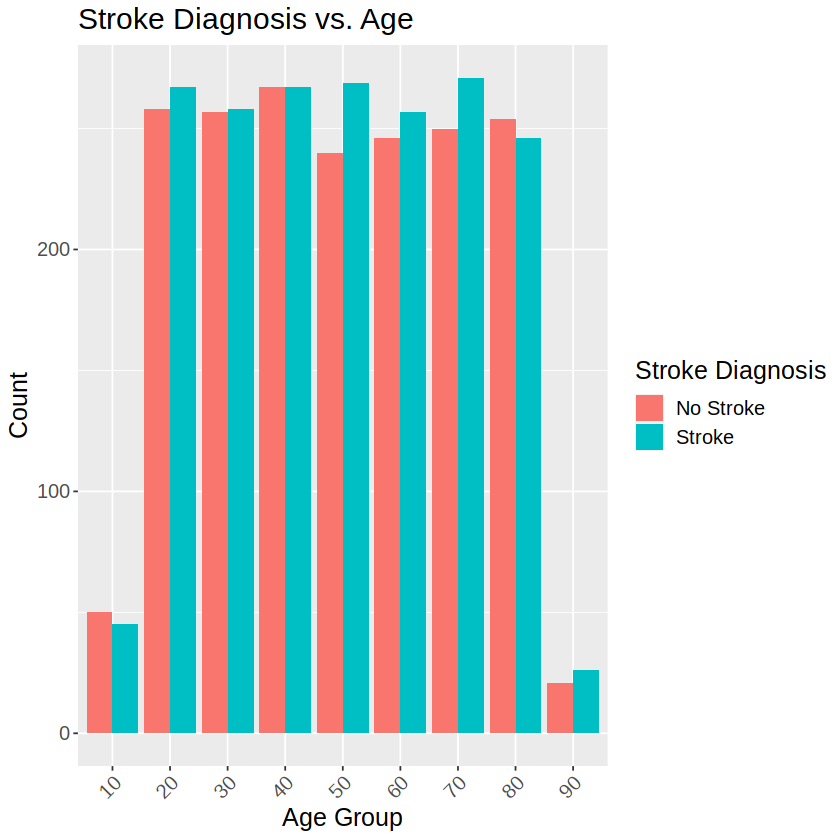

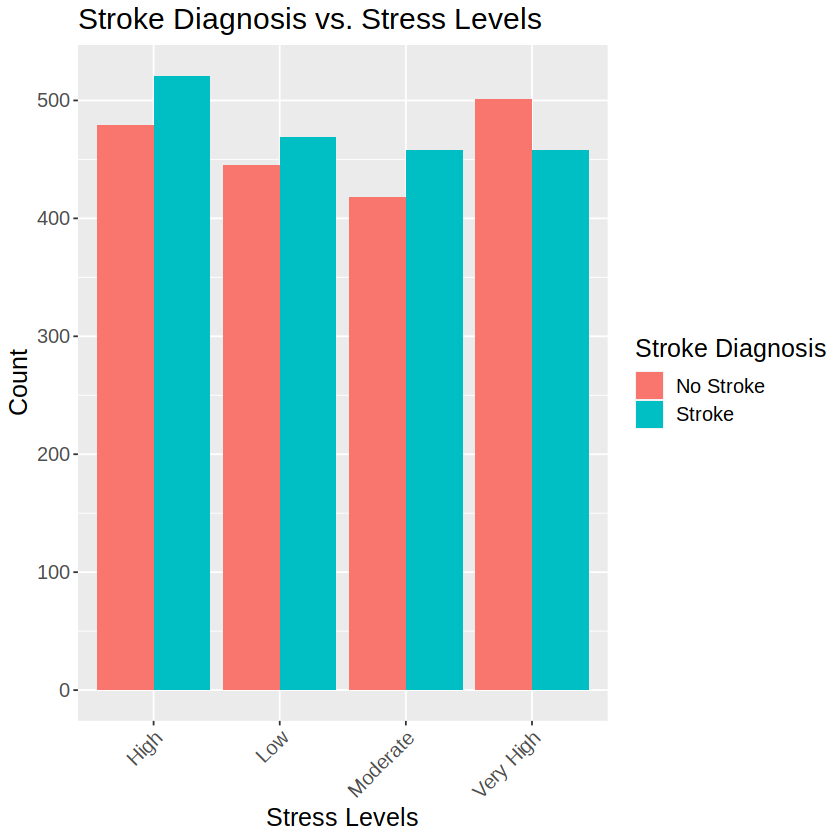

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7)

stroke_age <- stroke_training |>
            ggplot(aes(x = age_group, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Age Group", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Age") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_age

stroke_stress <- stroke_training |>
            ggplot(aes(x = stress_level_category, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Stress Levels", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Stress Levels") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_stress


### Step 3. Finding Optimal K

Our next step is to create a classification model where our goal is to identify an optimal *k* nearest neighbor value that will give us the highest accuracy. 

Since we are going to perform a cross-fold validation, we will need to further split our training group from earlier. After that, we created a recipe and standardized the variables. We set up the kknn classification model and instead of specifying a k value, we used *tune()*. Next, we performed 5 cross-validation folds with out subtrained data,collected metrics, then fit it in a workflow. After that, we filtered for accuracy and plotted the k values verses accuracy.

Based on the scatter plot k vs. Accuracy, the optimal value was found to be **k = 10** which gave an approximate accuracy of **51.4%**. This k value is optimal since it yielded the highest accuracy.

In [11]:
stroke_subvfold <- initial_split(stroke_training, prop = 0.75, strata = diagnosis_group) 
stroke_subtraining <- training(stroke_subvfold) 
stroke_validation <- testing(stroke_subvfold)

In [12]:
stroke_sub_recipe <- recipe(diagnosis_group ~ age + stress_levels, data = stroke_subtraining) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

In [13]:
stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

In [14]:
stroke_vfold <- vfold_cv(stroke_subtraining, v = 5, strata = diagnosis_group) 

grid_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

stroke_workflow <- workflow() |>
                    add_recipe(stroke_sub_recipe) |>
                    add_model(stroke_spec) |>
                    tune_grid(resamples = stroke_vfold, grid = grid_values) |>
                    collect_metrics()


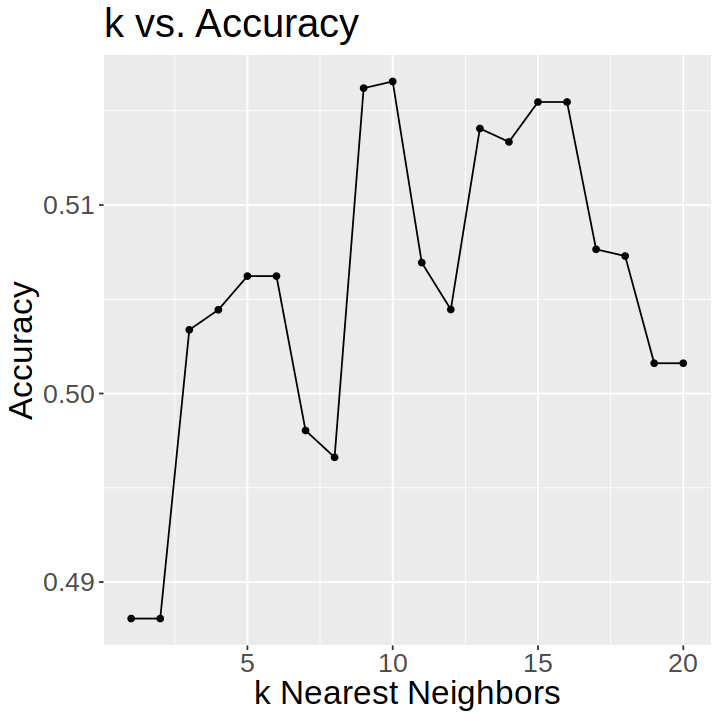

In [15]:
options(repr.plot.width = 6, repr.plot.height = 6)

stroke_accuracies <- stroke_workflow |>
                        filter(.metric == "accuracy") 
                        
cross_val_plot <- ggplot(stroke_accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                  labs(title = "k vs. Accuracy",
                       x = "k Nearest Neighbors",
                       y = "Accuracy") +
                  theme(text = element_text(size = 20))
cross_val_plot

### Step 4. Building The Classification Model

Following our model, we built a new model with our optimal k value (10), fit the data into the original training set, created a prediction using the original testing set, and then set up our confusion matrix. *elaborate on confusion matrix and accuracy*

In [22]:
stroke_spec_matrix <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
            set_engine("kknn") |>
            set_mode("classification")

stroke_recipe <- recipe(diagnosis_group ~ age + stress_levels, data = stroke_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

stroke_fit <- workflow() |>
            add_recipe(stroke_recipe) |>
            add_model(stroke_spec_matrix) |>
            fit(data = stroke_training)

### Step 5. Evaluating The Performance

The table below displays the accuracy of our model's graph which is ~51.4 %! This is close as upon observing the graph, the point at which our optimal k value gives the highest accuracy is indeed k = 10 at 51.4%.

In [17]:
# We created a table that shows the accuracy

stroke_predictions <- predict(stroke_fit, stroke_testing) |>
                        bind_cols(stroke_testing)

stroke_metrics <- stroke_predictions |>
                        metrics(truth = diagnosis_group, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
stroke_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5139888


In [18]:
# We converted .pred_class into a factor to put into the confusion matrix

stroke_predictions <- stroke_predictions |>
            mutate(.pred_class = fct_recode(.pred_class, "0" = "No Stroke", "1" = "Stroke"))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `.pred_class = fct_recode(.pred_class, `0` = "No Stroke", `1` =
  "Stroke")`.
Caused by warning:
! Unknown levels in `f`: No Stroke, Stroke”


In [19]:
stroke_conf_mat <- stroke_predictions |>
                conf_mat(truth = diagnosis_group, estimate = .pred_class)
stroke_conf_mat

          Truth
Prediction   0   1
         0 294 287
         1 321 349

In [35]:
# Now, we can perform calculations to find our accuracy, precision, and recall values.

accuracy <- (294 + 349)/(294 + 287 + 321 + 349) * 100
accuracy

precision <- 294/(294 + 287) * 100
precision

recall <- 294/(294 + 321) * 100
recall

[1] 51.39888

[1] 50.60241

[1] 47.80488

The confusion matrix is a tabular representation of our classification models performance. The '0' symbolizes 'No Stroke' and '1' symbolizes 'Stroke'. To calculate accuracy, we take the total number of correct predictions (294 + 349) and divide it by the total number of predictions. To calculate precision, we take the total number of correct positive predictions and divide it by total number of positive predictions. To calculate recall, we take the total number of correct positive predictions and divide it by the total number of positive test set predictions.

Let's take a deeper dive at each individual value. 294 represents a true positive. This means that a 'no stroke' observation was classified/predicted as 'no stroke'.

287 represents a false positive. This means that a 'stroke' observation was actually classified as a 'no stroke'

321 represents a false negative. This means that a 'no stroke' observation was actually classified as a 'stroke'

And 349 represents a true negative. This means that a 'stroke' observation was actually classified as a 'stroke'

Overall, the accuracy, precision, and recall are approximately 50%. The reasoning for this will be discussed later on.

### Step 5. Visualization of Results

Finally, we create a visualization of our results. The scatter plot on top represents the predicted values that was predicted and the scatter plot beneath represents the actual/tested values. The plots and points have been separated for easier visualization.

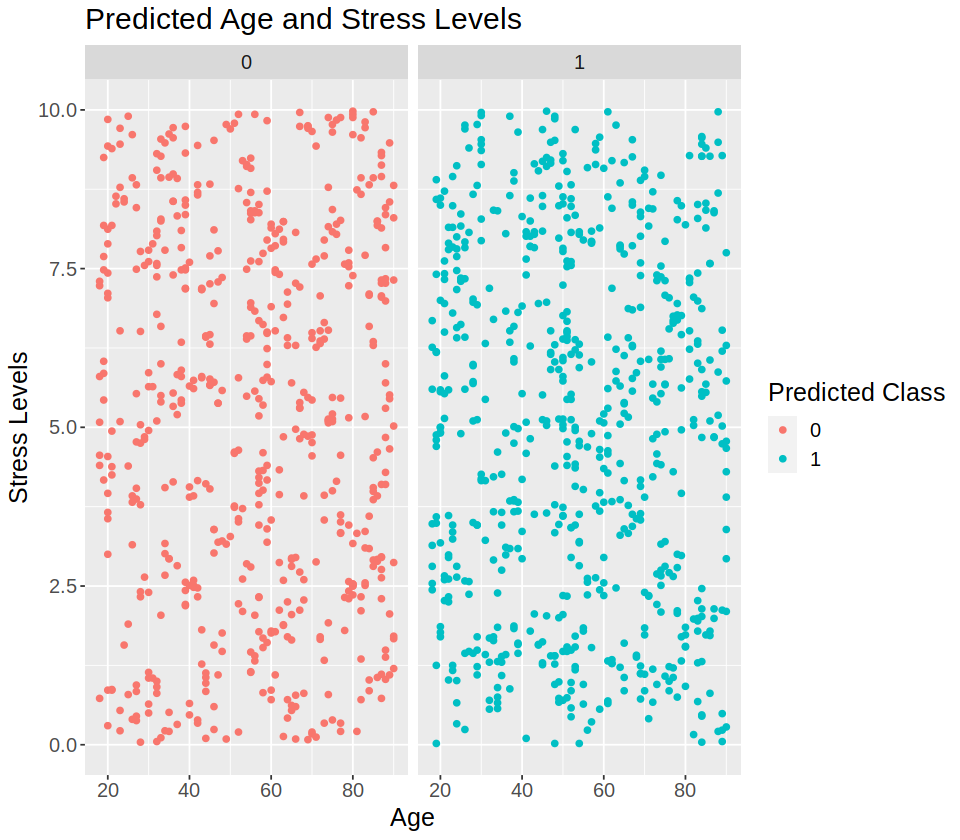

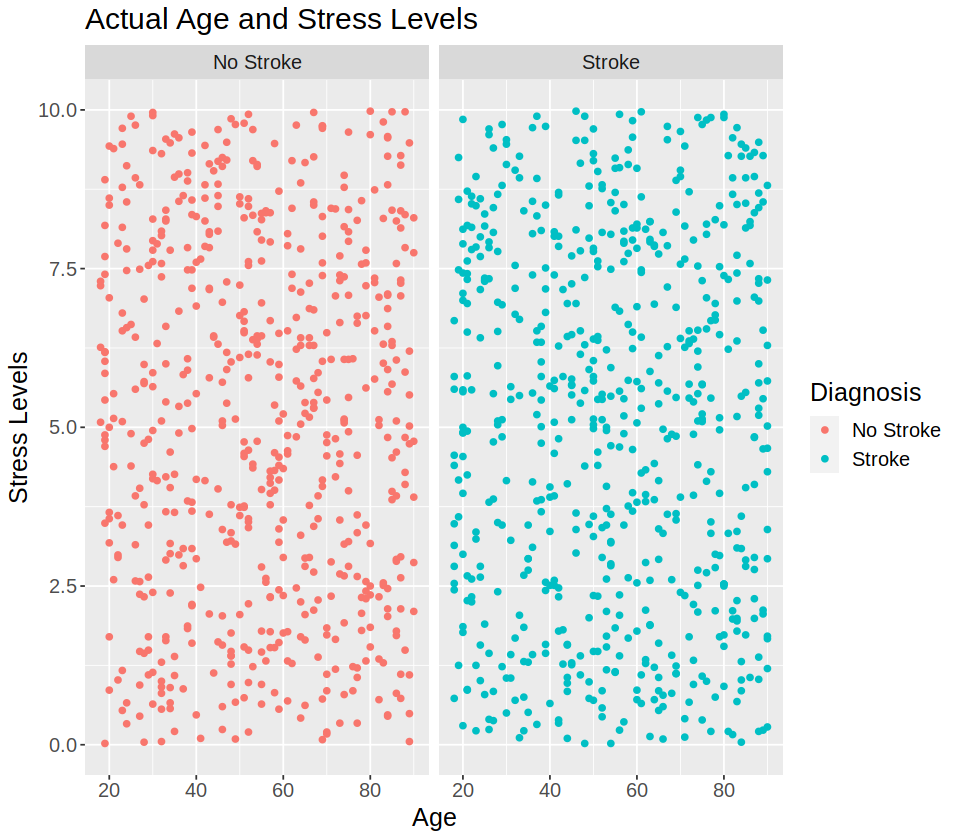

In [39]:
options(repr.plot.width = 8, repr.plot.height = 7)

stroke_plot_1 <- ggplot(stroke_predictions, aes(x = age, y = stress_levels, color = .pred_class)) +
                    geom_point() +
                labs(x = "Age",
                     y = "Stress Levels",
                     color = "Predicted Class",
                     title = "Predicted Age and Stress Levels") +
                theme(text = element_text(size = 15)) +
                facet_grid(~ .pred_class)

stroke_plot_2 <- ggplot(stroke_testing, aes(x = age, y = stress_levels, color = diagnosis)) +
                    geom_point() +
                labs(x = "Age",
                     y = "Stress Levels",
                     color = "Diagnosis",
                     title = "Actual Age and Stress Levels") +
                theme(text = element_text(size = 15)) +
                facet_grid(~ diagnosis)
stroke_plot_1
stroke_plot_2

After thoroughly comparing the two scatter plots, we can sort of see that there are less red points and more blue points in the predicted plots as compared to the actual/tested plot. This means that the classifier predicted more values as 'stroke' than 'no stroke.' In short, this aligns with our research questions, which will be further elaborated on.

## 3. Discussion and Conclusion

## 4. References

Venugopal, U., & Agur, A. (n.d.). Stroke Prediction. Kaggle. Retrieved from 
https://www.kaggle.com/datasets/teamincribo/stroke-prediction/data